# Introduction

In this exercise, Pima Indian diabetes dataset is explored and machine learning models and Neural Network with Keras are developed to predict if a person is going to have diabetes.  
Below is a nice video I got about this 5 minute diabetes study in Kaggle, please watch this.

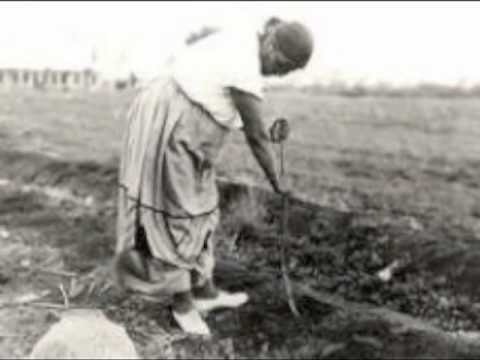

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("pN4HqWRybwk")

In [2]:
# Import the packages

import pandas as pd
import numpy as np
import itertools


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

import os
os.listdir()

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'project.ipynb']

## Loading and checking the dataset

In [3]:
diab=pd.read_csv('../input/diabetes.csv')

In [4]:
diab.isnull().sum()

There is no empty row for any of the columns. So we can start analyzng it.

In [5]:
diab.describe()

In [6]:
diab.info()

## Exploring the dataset

Outcome is the target column in the dataset. Outcome '1' is with diabetes and '0' is without diabetes, we get their total counts in the dataset. 
Other columns in the dataset will be input to the models. 
Let us have a look at the count of Outcome columns. 

In [7]:
sns.countplot(x='Outcome',data=diab)
plt.show()

Basic stat summary of the feature columns against the Outcome column to see any differences between having and not having diabetes.  
We can notice some mean differences between having diabetes and no diabetes (may not be statistically significant within certain confidence level). It will be difficult to judge though if you have many more columns.

In [8]:
grouped = diab.groupby('Outcome').agg({'Pregnancies':['mean', 'std', min, max], 
                                       'Glucose':['mean', 'std', min, max],
                                       'BloodPressure':['mean', 'std', min, max],
                                       'SkinThickness':['mean', 'std', min, max],
                                       'Insulin':['mean', 'std', min, max],
                                       'BMI':['mean', 'std', min, max],
                                       'DiabetesPedigreeFunction':['mean', 'std', min, max],
                                       'Age':['mean', 'std', min, max]
                                      })
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped # or grouped.T

Let us have look at the distribution of the features grouping them by the Outcome column.  
Outcome 0 is no diabetes, 1 is with diabetes.

In [9]:
columns=diab.columns[:8]
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(diab[columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(diab[cn][diab.Outcome == 1], bins=50)
    sns.distplot(diab[cn][diab.Outcome == 0], bins=50)
    ax.set_xlabel('')
    plt.legend(diab["Outcome"])
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

Distribution of diabetes cases are overall similar to distribution of non-diabetes distribution in each feature. No single parameter can explain the difference betweeen diabetes and non-diabetes. 

## Correlation matrix

In [10]:
sns.heatmap(diab[diab.columns[:8]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
plt.show()

Input parameters are not highly correlated. So we can keep all the parameters for the model. 
Another way to look at it is by doing pair plots.

# Proceed to model building

In [11]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

Split into train and test **stratify**ing the 'Outcome' column.  
This guarantees the train-test split ratio in the 'Outcome' column both in the training set and the testing set. 

In [12]:
outcome=diab['Outcome']
data=diab[diab.columns[:8]]
train,test=train_test_split(diab,test_size=0.25,random_state=0,stratify=diab['Outcome'])# stratify the outcome
train_X=train[train.columns[:8]]
test_X=test[test.columns[:8]]
train_Y=train['Outcome']
test_Y=test['Outcome']

### Feature Centering and Scaling

train_X and test_X datasets are centered to zero and normalized by the std dev. This helps in faster gradient descent.

In [13]:
features = train_X.columns.values

for feature in features:
    mean, std = diab[feature].mean(), diab[feature].std()
    train_X.loc[:, feature] = (train_X[feature] - mean) / std
    test_X.loc[:, feature] = (test_X[feature] - mean) / std

Let us compare al the models for their accuracy:


In [14]:
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Random forest', 'Naive Bayes']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), 
        RandomForestClassifier(n_estimators=100,random_state=0), GaussianNB()]
for i in models:
    model = i
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    abc.append(metrics.accuracy_score(prediction,test_Y))
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Accuracy']
models_dataframe.sort_values(['Accuracy'], ascending=[0])

We see that random forest classifier has better accuracy of 80.72%. Next, logistic regression and linear SVM has similar accuracy of more than 77%.
Let us look at the featureimportance in Random forest classifier.

In [15]:
modelRF= RandomForestClassifier(n_estimators=100,random_state=0)
modelRF.fit(train_X,train_Y)
predictionRF=modelRF.predict(test_X)
pd.Series(modelRF.feature_importances_,index=train_X.columns).sort_values(ascending=False)

Top five important features are 'Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction' and 'Blood pressure'. Next, pregnancies (only in case of women) have higher chances of diabetes.

### Cross validation

Most of the time, the dataset has imbalance in classes, say one or more class(es) has higher instances than the other classes. In that case, we should train the model in each and every instances of the dataset. After that we take average of all the noted accuracies over the dataset. 

1. For a K-fold cross validation, we first divide the dataset into K subsets. 
2. Then we train on K-1 parts and test on the remainig 1 part. 
3. We continue to do that by taking each part as testing and training on the remaining K-1. Accuracies and errors are then averaged to get an average accuracy of the algorithm.
4. For certain subset the algorithm will underfit while for a certain other it will overfit. With K-fold cross validation we achieve a generalized model.

Below we approach the K-fold cross validation for this dataset.

In [16]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.preprocessing import StandardScaler #Standardisation

In [17]:
kfold = KFold(n_splits=10, random_state=22) # k=10 splits the data into 10 equal parts

In [18]:
# Starting with the original dataset and then doing centering and scaling
features=diab[diab.columns[:8]]
features_standard=StandardScaler().fit_transform(features)# Gaussian Standardisation
X=pd.DataFrame(features_standard,columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                          'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
X['Outcome']=diab['Outcome']

In [19]:
xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Random forest', 'Naive Bayes']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), 
        RandomForestClassifier(n_estimators=100,random_state=0), GaussianNB()]

for i in models:
    model = i
    cv_result = cross_val_score(model,X[X.columns[:8]], X['Outcome'], cv = kfold, scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)

cv_models_dataframe=pd.DataFrame(xyz, index=classifiers)   
cv_models_dataframe.columns=['CV Mean']    
cv_models_dataframe
cv_models_dataframe.sort_values(['CV Mean'], ascending=[0])

In [20]:
box=pd.DataFrame(accuracy,index=[classifiers])
boxT = box.T

In [21]:
ax = sns.boxplot(data=boxT, orient="h", palette="Set2", width=.6)
ax.set_yticklabels(classifiers)
ax.set_title('Cross validation accuracies with different classifiers')
ax.set_xlabel('Accuracy')
plt.show()

The above plots shows that Linear SVM and Logistic Regression performs better in cross validation while tree based methods, Decision Tree and Random Forrest are worse with wider distribution of their acccuracies.

## Ensembling

In ensemble methods, we create multiple models and then combine them that gives us better results. Enseble methods typically gives better accuracy than a single model. The models used to create such ensemble models are called base models.  

Let us do ensembling with **Voting Ensemble**. First we create two or more standalone models on the training dataset. A voting classifier wrap the models to get average predictions. Models with higher individual accuracies are weighted higher.  

Since KNN, Decision Tree and Random Forest models have wide range of accuracies in K-fold validation, they are not considered in ensembling the models.

Other the models: Linear SVM, Radial SVM and Logistic Regression are combined together to get an ensemble model.

In [25]:
linear_svm=svm.SVC(kernel='linear',C=0.1,gamma=10, probability=True)
radial_svm=svm.SVC(kernel='rbf',C=0.1,gamma=10, probability=True)
lr=LogisticRegression(C=0.1)

In [26]:
from sklearn.ensemble import VotingClassifier #for Voting Classifier

### Ensamble with 3 classifiers combined: Linear SVM, radial SVM, Log Reg

In [27]:
ensembleModel=VotingClassifier(estimators=[('Linear_svm',linear_svm), ('Radial_svm', radial_svm), ('Logistic Regression', lr)], 
                                            voting='soft', weights=[2,1,3])

ensembleModel.fit(train_X,train_Y)
predictEnsemble = ensembleModel.predict(test_X)

In [28]:
print('Accuracy of ensembled model with all the 3 classifiers is:', np.round(ensembleModel.score(test_X,test_Y), 4))

**### ROC curve with AUC

In [29]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

In [31]:
# Logistic regression
modelLR = LogisticRegression()
modelLR.fit(train_X,train_Y)
y_pred_prob_lr = modelLR.predict_proba(test_X)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_Y, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(test_Y, y_pred_prob_lr)

# SVM with rbf
modelSVMrbf=svm.SVC(kernel='rbf', probability=True)
modelSVMrbf.fit(train_X,train_Y)
y_pred_prob_SVMrbf = modelSVMrbf.predict_proba(test_X)[:,1]
fpr_SVMrbf, tpr_SVMrbf, thresholds_SVMrbf = roc_curve(test_Y, y_pred_prob_SVMrbf)
roc_auc_SVMrbf = auc(fpr_SVMrbf, tpr_SVMrbf)
precision_SVMrbf, recall_SVMrbf, th_SVMrbf = precision_recall_curve(test_Y, y_pred_prob_SVMrbf)

# SVM with linear
modelSVMlinear=svm.SVC(kernel='linear', probability=True)
modelSVMlinear.fit(train_X,train_Y)
y_pred_prob_SVMlinear = modelSVMlinear.predict_proba(test_X)[:,1]
fpr_SVMlinear, tpr_SVMlinear, thresholds_SVMlinear = roc_curve(test_Y, y_pred_prob_SVMlinear)
roc_auc_SVMlinear = auc(fpr_SVMlinear, tpr_SVMlinear)
precision_SVMlinear, recall_SVMlinear, th_SVMlinear = precision_recall_curve(test_Y, y_pred_prob_SVMlinear)

# KNN
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelKNN.fit(train_X,train_Y)
y_pred_prob_KNN = modelKNN.predict_proba(test_X)[:,1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(test_Y, y_pred_prob_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
precision_KNN, recall_KNN, th_KNN = precision_recall_curve(test_Y, y_pred_prob_KNN)


# Decision Tree
modelTree=DecisionTreeClassifier()
modelTree.fit(train_X,train_Y)
y_pred_prob_Tree = modelTree.predict_proba(test_X)[:,1]
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(test_Y, y_pred_prob_Tree)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(test_Y, y_pred_prob_Tree)

# Random forest
modelRF= RandomForestClassifier(n_estimators=100,random_state=0)
modelRF.fit(train_X,train_Y)
y_pred_prob_rf = modelRF.predict_proba(test_X)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_Y, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, th_rf = precision_recall_curve(test_Y, y_pred_prob_rf)


# Naive Bayes
modelNB= GaussianNB()
modelNB.fit(train_X,train_Y)
y_pred_prob_nb = modelNB.predict_proba(test_X)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_Y, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(test_Y, y_pred_prob_nb)

# Ensamble 
y_pred_prob_en = ensembleModel.predict_proba(test_X)[:,1]
fpr_en, tpr_en, thresholds_en = roc_curve(test_Y, y_pred_prob_en)
roc_auc_en = auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = precision_recall_curve(test_Y, y_pred_prob_en)

In [32]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Log Reg (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_SVMrbf, tpr_SVMrbf, label='SVM rbf (area = %0.3f)' % roc_auc_SVMrbf)
plt.plot(fpr_SVMlinear, tpr_SVMlinear, label='SVM linear (area = %0.3f)' % roc_auc_SVMlinear)
plt.plot(fpr_KNN, tpr_KNN, label='KNN (area = %0.3f)' % roc_auc_KNN)
plt.plot(fpr_Tree, tpr_Tree, label='Tree (area = %0.3f)' % roc_auc_Tree)
plt.plot(fpr_rf, tpr_rf, label='RF (area = %0.3f)' % roc_auc_rf)
plt.plot(fpr_nb, tpr_nb, label='NB (area = %0.3f)' % roc_auc_nb)
plt.plot(fpr_en, tpr_en, label='Ensamble (area = %0.3f)' % roc_auc_en)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

We see that Tree, KNN, RF and NB models are somewhat worse compared to the other models in AUC.  
Ensamble model is not standing out compared to LogReg and SVM models.  
Nevertheless, **ensamble model is expected to be more robust for any future addition of training data**.  

### Precision-recall curve comparing the models

In [33]:
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(recall_lr, precision_lr, label='Log Reg')
plt.plot(recall_SVMrbf, precision_SVMrbf, label='SVM rbf')
plt.plot(recall_SVMlinear, precision_SVMlinear, label='SVM linear')
plt.plot(recall_KNN, precision_KNN, label='KNN')
plt.plot(recall_Tree, precision_Tree, label='Tree')
plt.plot(recall_rf, precision_rf, label='RF')
plt.plot(recall_nb, precision_nb, label='NB')
plt.plot(recall_en, precision_en, label='Ensamble')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

With higher recall (outcome = 1 i.e. having diavetes), precision (outcome=0, i.e. no diabetes)  goes down.   
Again the ensamble model is comparable to LogReg and SVM models and other models are worse.

### Confusion matrix with ensamble model
> 
Let us look at the confusion matrix from the ensamble classifier.  
First define a function to plot confusion matrix

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
class_names = test_Y.unique()
cmEnsamble = confusion_matrix(test_Y, predictEnsemble)
plot_confusion_matrix(cmEnsamble, classes=class_names, title='Confusion matrix with ensamble model, without normalization')

> ## Model report with ensamble model

In [36]:
print(metrics.classification_report(test_Y, predictEnsemble))

Looking at the recall scores for 0 (no diabetes) and 1 (having diabetes), the model did well for predicting no diabetes (correct 92% of the time) while did not do that well for predicting diabetes (correct 54% of the time).  So, there is room for improving prediction for diabetes.  


## Diabetes prediction using Neural Network with Keras

Keras is a high level frame work for running neural network applications. It runs tensorflow at the backend.  
Below I practiced applying fully connected neural network in Keras and directly in Tensowflow using relatively small network.  
This Diabetes dataset is small for neural network applications and to get a better accuracy. 
I believe the **ensemble model** above is better approach for this dataset.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# fix random seed for reproducibility
np.random.seed(2)

In [38]:
train_Y = to_categorical(train_Y, num_classes = 2)
test_Y = to_categorical(test_Y, num_classes = 2)

In [39]:
# Confirm the train-test split ratio
print(np.shape(train_X))
print(np.shape(train_Y))
print(np.shape(test_X))
print(np.shape(test_Y))

### 1. Create the model using Keras

input_dim = 8 since we have 8 input variable.  
Here we are using 5 fully connected layers defined by using the Dense class (no particular reason for 5 layers, typically more layers are better). 
Number of neurons in the layers are the first argument (8, 12, 12, 8, 4 & 1 respecitvely here).  
We use the default weight initialization in Keras which is between 0 to 0.05 assuming "uniform" distribution.  
First 4 layers have "relu" activation and output layer has "sigmoid" activation. Sigmoid on the output layer ensures that we have output between 0  and 1.  

We can piece it all together by adding each layer.

In [40]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 2. Compile the model


Now the model is ready, we can compile it (using tensorflow under the hood or backend) and train it find the best weights for prediction. 
loss='binary_crossentropy' since the problem is binary classification.  
optimizer='adam' since it is efficient and default default.  
From metrics we collect the accuracy.

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3. Fit model

We train the model by calling fit() on training data.  
The number of iteration through the whole training datset is called "epoch". It is set to 150 (higher the better).  
The number of instances that are evaluated before a weight update in the network is performed is the the batch size. It is set to 50 (relatively small, the dataset is also small).  

With the model.fit(), we shall also capture the accuracy each epoch.

In [42]:
epoch = 150
batch_size = 50

history = model.fit(train_X, train_Y, batch_size = batch_size, epochs = epoch, 
          validation_data = (test_X, test_Y), verbose = 2)

We see that the model accuracy hovers around 78% in the testing data which is not better than ensemble model (accuracy may change slightly run-to-run). We can try larger network inclear number of epochs however, very likely this is the maximum prediction or performance of the model based on the dataset. We may also end of overfitting the training dataset. Again, note that the dataset is relatively small for neural network. 

### 4 Evaluate model

We evaluate the model on test dataset and obtain the score and accuracy.  
Score is the evaluation of the loss function for a given input.

In [43]:
score, acc = model.evaluate(test_X, test_Y)
print('Test score:', score)
print('Test accuracy:', acc)

So we get 77.86% accuracy on the test dataset with this fully connected neural network (varies little bit run to run).  
This is **comparable and not significantly better than ensemble method** done earlier.  
NN acccuracy expected to improve with larger amount of training data.

### Training and validation curves vs. epoch

In [44]:
# Plot the loss and accuracy curves for training and validation vs. epochs

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

After about 85 epochs, testing loss starts to  become higher than training loss and exactly opposite for accuracy: testing accuracy starts to get lower than training accuracy. Basically we are starting to overfit here.  
Therefore, we get an optimal accuracy of close to 80% using this model.

### Confusion matrix using this model

Let us have a look at the correct and misclasssification in the confusion matrix.  
I am using the below function for confusion matrix.


In [45]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_Y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

plt.show()

In [46]:
print(metrics.classification_report(Y_true, Y_pred_classes))

This NN model is able to predict diabetes on 66% of actuall diabetes classes which is better than the ensamble model.

## t-SNE plot


In [47]:
df_std = StandardScaler().fit_transform(diab)
y = diab.iloc[:,-1].values

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
x_t = tsne.fit_transform(df_std)

In [51]:
color_map = {0:'red', 1:'blue'}
plt.figure()
plt.figure()
plt.scatter(x_t[np.where(y == 0), 0], x_t[np.where(y == 0), 1], marker='x', color='g', 
            linewidth='1', alpha=0.8, label='No diabetes')
plt.scatter(x_t[np.where(y == 1), 0], x_t[np.where(y == 1), 1], marker='v', color='r',
            linewidth='1', alpha=0.8, label='Diabetes')

plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of diabetes data')
plt.show()

We see that diabetes (1) and non-diabetic (0) are well separated in tSNE plot of the dataset.

### Conclusion

* Close to 80% overall accuracy is obtained based on this dataset to predict diabetes in a person using ensemble model among different methods evalauted as well as NN model.  
* Non diabetes cases are predicted more accurately than diabetes cases.  
* NN model gave better prediction of diabetes cases than ensamble model (66% vs. 54%).
* Based on Random Forest feature importance, Glucose, BMI, Age and diabetes pedigree are top causes for diabetes. 
* Based on parameter correlation, no given single parameter can predict diabetes. 
* More data, feature engineering and larger NN model is expected to improve diabetes prediction accuracy.

** With help from several Kaggle notebooks.**